# Video Game Sales

### The global video game industry is a billion-dollar business and has been for many years. In 2022, the revenue from the worldwide gaming market was estimated at almost 347 billion U.S. dollars, with the mobile gaming market generating an estimated 248 billion U.S. dollars of the total. (https://www.statista.com/topics/868/video-games/)   

#### By analyzing variables connected to previously released games, there might be a possibility to train a machine learning model to help predict future sales, and also what kind of games would generate the most money.

In [15]:
import pandas as pd
import numpy as np

In [16]:
# https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings/data
video_games_sales=pd.read_csv("Video_Games_Sales_as_at_22_Dec_2016.csv")

# EDA

In [17]:
# Global_Sales will be the predictor variable in this case.
video_games_sales.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


### Explaining the column names

From the data info:

Fields include:
   
    Name - The games name    
    Platform - Platform of the games release (i.e. PC,PS4, etc.)    
    Year - Year of the game's release
    Genre - Genre of the game
    Publisher - Publisher of the game
    NA_Sales - Sales in North America (in millions)
    EU_Sales - Sales in Europe (in millions)
    JP_Sales - Sales in Japan (in millions)
    Other_Sales - Sales in the rest of the world (in millions)
    Global_Sales - Total worldwide sales.
    Critic_score - Aggregate score compiled by Metacritic staff
    Critic_count - The number of critics used in coming up with the Critic_score
    User_score - Score by Metacritic's subscribers
    User_count - Number of users who gave the user_score
    Developer - Party responsible for creating the game
    Rating - The ESRB ratings


In [18]:
# There seems to be missing values, especially at the score columns. 
# Column 13, User_Count, is missing more than 50% of the total values.
# Strings are in object type, which might be ok?
# User_Score are of type object and not float like Critics_Score.
video_games_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


In [19]:
# Missing values:
# Name, Year_of_Release and other columns with smaller count might have their rows dropped.
# The score columns are not easily dropped without risking an underfitted model.
video_games_sales.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

### What score values are missing, and why? (Chart)

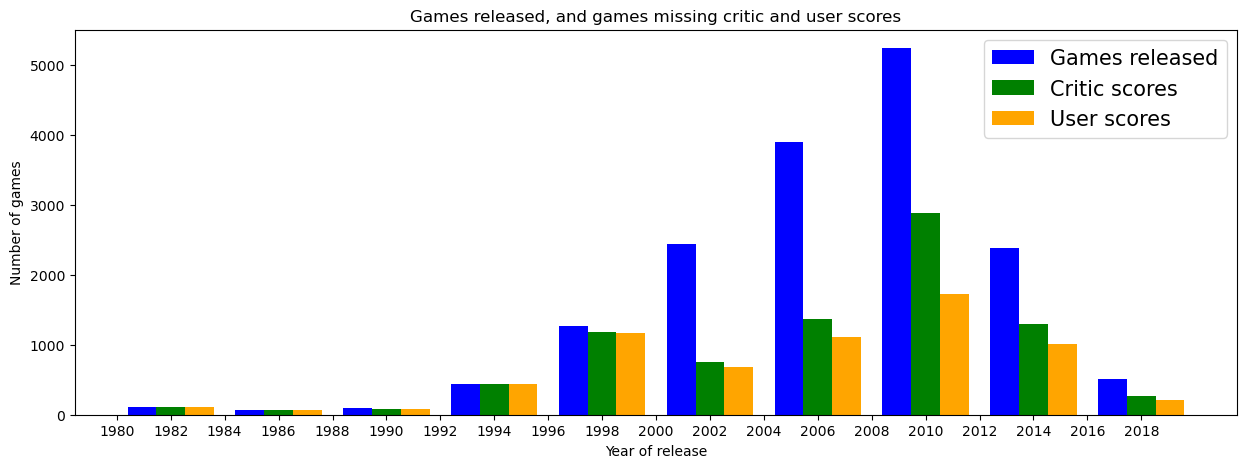

In [20]:
# What score values are missing, and why?
# Here we see that many games around the year 2010 are missing scores, and not many games in the years pre-2000 are missing scores.
# The years pre-2000 not missing many scores can however be due to there not being released as many games in that time period, as seen in tha chart below. 

import matplotlib.pyplot as plt
df = pd.DataFrame(video_games_sales)

# Make a custom list with years for better xticks.
xTicksCount = int(df.Year_of_Release.max()) - int(df.Year_of_Release.min())
tickArray = []
for i in range(xTicksCount):
    if ((int(df.Year_of_Release.min()) + i) % 2 == 0):        
        tickArray.append(int(df.Year_of_Release.min()) + i)


plt.figure(figsize=(15, 5))
x = [df.loc[df.Name.isna() == False, 'Year_of_Release'],
     df.loc[df.Critic_Score.isna(), 'Year_of_Release'],
     df.loc[df.User_Score.isna(), 'Year_of_Release']]
colors = ['blue','green', 'orange']
names = ['Games released','Critic scores', 'User scores']

n_bins = 10
plt.hist(x, n_bins, color=colors, label=names)
plt.xlabel("Year of release")
plt.ylabel("Number of games")
plt.title("Games released, and games missing critic and user scores")
plt.legend(prop={'size': 15})
plt.xticks(tickArray)
plt.show()

### Correlation matrix where categorical columns have been converted to numerical values (in a single column, and not in many which is better used for the machine learning process).

In [21]:
# It might be best to handle missing data before checking correlations between columns, but since there are a lot of missing
# values, there could be trust issues after the possible imputations.

# converting type of columns to 'category'
df['Platform'] = df['Platform'].astype('category')
df['Name'] = df['Name'].astype('category')
df['Rating'] = df['Rating'].astype('category')
df['User_Score'] = df['User_Score'].astype('category')



df['Genre'] = df['Genre'].astype('category')
df['Publisher'] = df['Publisher'].astype('category')
df['Developer'] = df['Developer'].astype('category')

# Assigning numerical values and storing in another column
df['Platform_cat'] = df['Platform'].cat.codes
df['Name_cat'] = df['Name'].cat.codes
df['Rating_cat'] = df['Rating'].cat.codes
df['User_Score_cat'] = df['User_Score'].cat.codes



df['Genre_cat'] = df['Genre'].cat.codes
df['Publisher_cat'] = df['Publisher'].cat.codes
df['Developer_cat'] = df['Developer'].cat.codes

# Correlation matrix on numerical columns
corr = df.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

# Sales in regions seems to have more correlation with global sales, which is not surprising.
# These sales columns might be too similar/connected to Global_Sales and create overfitting if they are included in the model training. 
# Critic count seem to have some correlation, which seem logical. A popular game might get more attention from critics.
# Critic score and user count also have some correlation, but there arent many strong correlations with global sales.
# Year or release, platform, genre, publisher and developer seem to have weak correlations and could possibly be removed.
# This leaves the model training with the columns that are missing a lot of values, which is a bad sign.

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count,Platform_cat,Name_cat,Rating_cat,User_Score_cat,Genre_cat,Publisher_cat,Developer_cat
Year_of_Release,1.000000,-0.092562,0.003842,-0.168386,0.037700,-0.076433,0.011411,0.223407,0.175339,0.172032,-0.003648,0.174716,0.186572,-0.129007,0.031729,0.197920
NA_Sales,-0.092562,1.000000,0.765336,0.449598,0.638654,0.941010,0.240755,0.295413,0.246429,0.040758,0.012128,0.055807,0.067547,0.019268,0.002621,0.073501
EU_Sales,0.003842,0.765336,1.000000,0.435068,0.722796,0.901239,0.220752,0.277533,0.283360,0.044896,0.006186,0.068188,0.067710,0.019145,0.010575,0.082371
JP_Sales,-0.168386,0.449598,0.435068,1.000000,0.291096,0.612300,0.152593,0.180219,0.075638,-0.079609,0.016284,-0.090056,-0.114055,0.030957,0.051612,-0.087047
Other_Sales,0.037700,0.638654,0.722796,0.291096,1.000000,0.749242,0.198554,0.251639,0.238982,0.054925,-0.006589,0.089971,0.090932,0.011820,0.013072,0.099543
Global_Sales,-0.076433,0.941010,0.901239,0.612300,0.749242,1.000000,0.245471,0.303571,0.265012,0.026729,0.010845,0.044386,0.045728,0.023955,0.016629,0.060033
Critic_Score,0.011411,0.240755,0.220752,0.152593,0.198554,0.245471,1.000000,0.425504,0.264376,0.018264,0.029438,0.040429,0.307092,0.140810,0.000688,0.022942
Critic_Count,0.223407,0.295413,0.277533,0.180219,0.251639,0.303571,0.425504,1.000000,0.362334,0.230113,-0.000979,0.248871,-0.005518,-0.010218,0.036075,0.034344
User_Count,0.175339,0.246429,0.283360,0.075638,0.238982,0.265012,0.264376,0.362334,1.000000,-0.006800,-0.038648,0.094063,0.027021,0.008179,0.016235,-0.012620
Platform_cat,0.172032,0.040758,0.044896,-0.079609,0.054925,0.026729,0.018264,0.230113,-0.006800,1.000000,0.014966,0.219699,0.094021,0.025860,-0.010843,0.117190


## Handling missing data

In [39]:
df_2 = df.dropna()
# Drop columns
df_2 = df.drop(['Platform', 'Name', 'Genre', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Developer', 'Rating'], axis=1)

df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year_of_Release  16450 non-null  float64
 1   Global_Sales     16719 non-null  float64
 2   Critic_Score     8137 non-null   float64
 3   Critic_Count     8137 non-null   float64
 4   User_Score       10015 non-null  object 
 5   User_Count       7590 non-null   float64
dtypes: float64(5), object(1)
memory usage: 783.8+ KB


In [67]:
df = pd.DataFrame(video_games_sales)
df = df.dropna()

one_hot_encoded_data = pd.get_dummies(df, dtype=int, columns = ['Rating', 'Genre'])
print(one_hot_encoded_data)

                                    Name Platform  Year_of_Release  \
0                             Wii Sports      Wii           2006.0   
2                         Mario Kart Wii      Wii           2008.0   
3                      Wii Sports Resort      Wii           2009.0   
6                  New Super Mario Bros.       DS           2006.0   
7                               Wii Play      Wii           2006.0   
...                                  ...      ...              ...   
16667         E.T. The Extra-Terrestrial      GBA           2001.0   
16677     Mortal Kombat: Deadly Alliance      GBA           2002.0   
16696  Metal Gear Solid V: Ground Zeroes       PC           2014.0   
16700                             Breach       PC           2011.0   
16706            STORM: Frontline Nation       PC           2011.0   

                          Publisher  NA_Sales  EU_Sales  JP_Sales  \
0                          Nintendo     41.36     28.96      3.77   
2                    

In [80]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import root_mean_squared_error
import pandas as pd
import numpy as np

df = pd.DataFrame(video_games_sales)
df = df.dropna()
df['User_Score_2'] = df['User_Score'].astype(float)
df = df.drop('User_Score', axis=1)
#df_2.is_copy = False
#print(df.info())

# Drop columns
df = df.drop(['Name', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Developer', 'Publisher', 'Rating', 'Genre'], axis=1)

df = pd.get_dummies(df, dtype=int, columns = ["Platform"])
print(df)
"""
df = pd.get_dummies(
    data=df, 
    prefix=None, 
    prefix_sep='_', 
    dummy_na=False, 
    columns=['Rating', 'Genre'], 
    sparse=False, 
    drop_first=False, 
    dtype=None
)
"""
X = df.drop('Global_Sales', axis=1) 
y = df['Global_Sales'] 

ss = StandardScaler() 

X_scaled = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 0)

regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

root_mean_squared_error(y_test, y_pred)
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

       Year_of_Release  Global_Sales  Critic_Score  Critic_Count  User_Count  \
0               2006.0         82.53          76.0          51.0       322.0   
2               2008.0         35.52          82.0          73.0       709.0   
3               2009.0         32.77          80.0          73.0       192.0   
6               2006.0         29.80          89.0          65.0       431.0   
7               2006.0         28.92          58.0          41.0       129.0   
...                ...           ...           ...           ...         ...   
16667           2001.0          0.01          46.0           4.0        21.0   
16677           2002.0          0.01          81.0          12.0         9.0   
16696           2014.0          0.01          80.0          20.0       412.0   
16700           2011.0          0.01          61.0          12.0        43.0   
16706           2011.0          0.01          60.0          12.0        13.0   

       User_Score_2  Developer_10tacle 

-2.329985529913627e+28